In [1]:
# READ DATA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from google.colab import files
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
import numpy as np
import tensorflow as tf
import random

# Import Data

In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/Mluthfialgifari/Tugas-Akhir-Skripsi/refs/heads/main/Revisi%20Analisis/Data%20TMA%20(Jan%202022%20-%20Juni%202025).csv')
data = data.loc[:, ['Daily_Period', 'TMA_Daily']]
data = data.iloc[972:1215].reset_index(drop=True)

print(data.head())
print(data.tail())

  Daily_Period  TMA_Daily
0   30/08/2024  10.000000
1   31/08/2024  10.000000
2   01/09/2024  10.000000
3   02/09/2024  10.833333
4   03/09/2024  10.000000
    Daily_Period  TMA_Daily
238   25/04/2025  20.000000
239   26/04/2025  20.000000
240   27/04/2025  20.000000
241   28/04/2025  21.666667
242   29/04/2025  20.000000


In [4]:
print(data.describe())

        TMA_Daily
count  243.000000
mean    20.084869
std     10.850430
min     10.000000
25%     10.000000
50%     20.000000
75%     24.166667
max     80.833333


# Eksplorasi Data

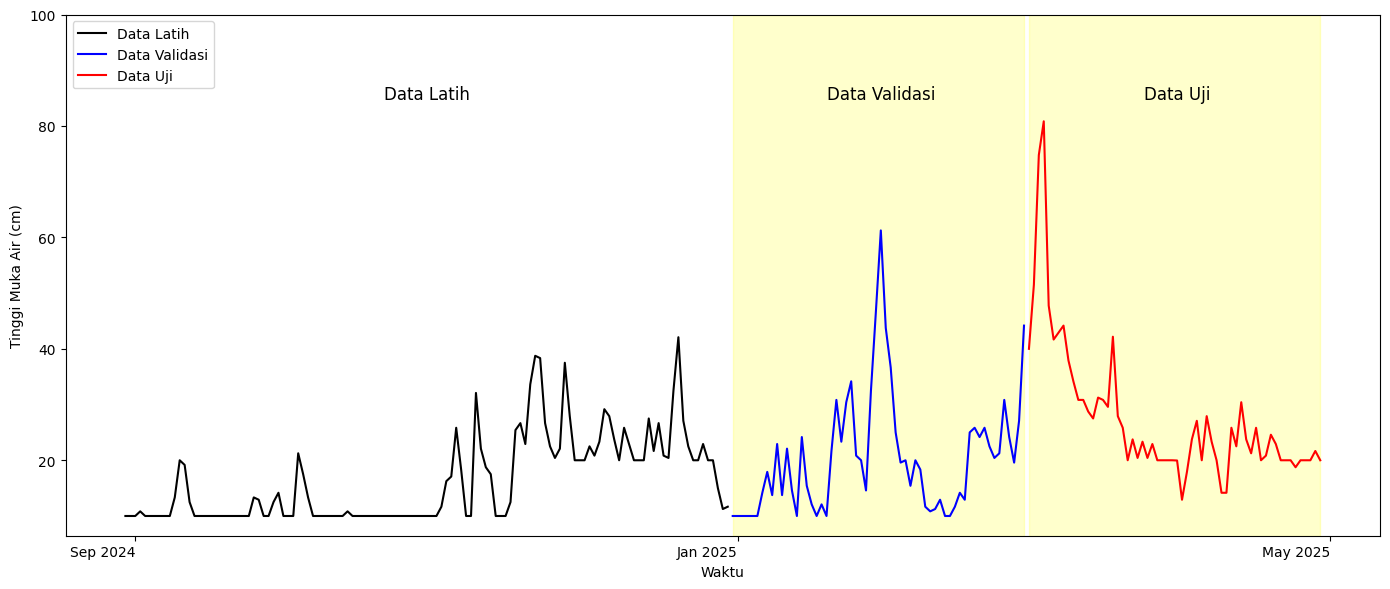

Dimensi Data Latih: (123, 2)
Dimensi Data Validasi: (60, 2)
Dimensi Data Uji: (60, 2)


In [5]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator
import pandas as pd

# Konversi tanggal
data['Daily_Period'] = pd.to_datetime(data['Daily_Period'], format='%d/%m/%Y')

# Pemisahan data
train_data = data.iloc[:123]
val_data = data.iloc[123:183]
test_data = data.iloc[183:]

# Plot
plt.figure(figsize=(14, 6))

plt.plot(train_data['Daily_Period'], train_data['TMA_Daily'], label='Data Latih', color='black')
plt.plot(val_data['Daily_Period'], val_data['TMA_Daily'], label='Data Validasi', color='blue')
plt.plot(test_data['Daily_Period'], test_data['TMA_Daily'], label='Data Uji', color='red')

# Highlight area validasi dan uji
plt.axvspan(val_data['Daily_Period'].iloc[0],
            val_data['Daily_Period'].iloc[-1],
            color='yellow', alpha=0.2)
plt.axvspan(test_data['Daily_Period'].iloc[0],
            test_data['Daily_Period'].iloc[-1],
            color='yellow', alpha=0.2)

# Tambahkan label sumbu dan judul
plt.xlabel('Waktu')
plt.ylabel('Tinggi Muka Air (cm)')
# plt.title('Plot Data Latih, Validasi, dan Uji')
plt.ylim(top=100)

# Format dan tampilan waktu di sumbu x
plt.gca().xaxis.set_major_locator(MonthLocator(bymonth=[1, 5, 9]))
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate(rotation=0)

# Tambahkan teks label di atas area masing-masing
plt.text(train_data['Daily_Period'].iloc[len(train_data)//2],
         data['TMA_Daily'].max() * 1.05,
         'Data Latih', ha='center', fontsize=12)
plt.text(val_data['Daily_Period'].iloc[len(val_data)//2],
         data['TMA_Daily'].max() * 1.05,
         'Data Validasi', ha='center', fontsize=12)
plt.text(test_data['Daily_Period'].iloc[len(test_data)//2],
         data['TMA_Daily'].max() * 1.05,
         'Data Uji', ha='center', fontsize=12)

# Tampilkan legenda dan plot
plt.legend()
plt.tight_layout()
plt.show()

# Cetak dimensi
print('Dimensi Data Latih:', train_data.shape)
print('Dimensi Data Validasi:', val_data.shape)
print('Dimensi Data Uji:', test_data.shape)

# Hyperparameter Tuning LSTM

In [6]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.initializers import HeUniform

In [7]:
# Mengambil kolom 'TMA_Daily' sebagai data yang akan diprediksi
time_series_data = data['TMA_Daily'].values.reshape(-1, 1)

# Normalisasi data ke rentang 0-1
scaler = MinMaxScaler()
time_series_data = scaler.fit_transform(time_series_data)

# Menentukan ukuran dataset
train_size = 123
val_size = 60
test_size = len(time_series_data) - train_size - val_size

# Membagi data menjadi train, val, test
train_data = time_series_data[:train_size]
val_data = time_series_data[train_size:train_size+val_size]
test_data = time_series_data[train_size+val_size:]

# Fungsi untuk membuat dataset dengan sekuens deret waktu
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

# Panjang sekuens deret waktu
seq_length = 30

# Membuat dataset sekuens
X_train = create_sequences(train_data, seq_length)
X_val = create_sequences(val_data, seq_length)
X_test = create_sequences(test_data, seq_length)

# Memisahkan fitur dan target
y_train = X_train[:, -1]
X_train = X_train[:, :-1]

y_val = X_val[:, -1]
X_val = X_val[:, :-1]

y_test = X_test[:, -1]
X_test = X_test[:, :-1]

# Reshape untuk input LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Fungsi untuk membuat model LSTM
def create_model():
    optimizer = Adam(learning_rate=0.005)
    model = Sequential()
    model.add(LSTM(
        50,
        activation='tanh',
        input_shape=(seq_length - 1, 1),
        kernel_initializer=HeUniform(),
        recurrent_initializer=HeUniform(),
        bias_initializer='zeros'
    ))
    model.add(Dropout(0.01))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Fungsi menghitung AIC
def calculate_aic(n, mse, num_params):
    aic = n * np.log(mse) + 2 * num_params
    return aic

# Inisialisasi model
model = create_model()

# List nilai AIC tiap epoch
aic_values = []

# Epoch yang akan diuji
epochs_to_test = [10, 50, 100, 150, 200, 250]

# Training dan evaluasi dengan AIC menggunakan data validasi (bukan test)
for epoch in epochs_to_test:
    model.fit(X_train, y_train, epochs=epoch, batch_size=64, verbose=0,
              validation_data=(X_val, y_val))

    # Prediksi pada data validasi (bukan test!)
    y_pred = model.predict(X_val)

    # Hitung MSE dan AIC
    mse = mean_squared_error(y_val, y_pred)
    n = len(y_val)
    num_params = model.count_params()  # jumlah parameter trainable
    aic = calculate_aic(n, mse, num_params)

    aic_values.append(aic)
    print(f"Epoch {epoch} - AIC: {aic}")

# Menampilkan hasil
print("AIC untuk setiap epoch yang diuji:", aic_values)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Epoch 10 - AIC: 20773.737375104287
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 50 - AIC: 20779.832310227364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 100 - AIC: 20801.413076546898
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 150 - AIC: 20825.119619253197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 200 - AIC: 20829.67407744313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 250 - AIC: 20827.120787306667
AIC untuk setiap epoch yang diuji: [np.float64(20773.737375104287), np.float64(20779.832310227364), np.float64(20801.413076546898), np.float64(20825.119619253197), np.float64(20829.67407744313), np.float64(20827.120787306667)]


In [8]:
print(X_train)

[[[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.04705882]
  [0.04117647]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.01176471]
  ...
  [0.04117647]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.01176471]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.03529412]]

 ...

 [[0.25294118]
  [0.14117647]
  [0.14117647]
  ...
  [0.14117647]
  [0.18235294]
  [0.14117647]]

 [[0.14117647]
  [0.14117647]
  [0.14117647]
  ...
  [0.18235294]
  [0.14117647]
  [0.14117647]]

 [[0.14117647]
  [0.14117647]
  [0.17647059]
  ...
  [0.14117647]
  [0.14117647]
  [0.07058824]]]


In [9]:
print(X_val)

[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.05882353]
  [0.11176471]
  [0.05294118]
  [0.18235294]
  [0.05294118]
  [0.17058824]
  [0.06470588]
  [0.        ]
  [0.2       ]
  [0.07647059]
  [0.02941176]
  [0.        ]
  [0.02941176]
  [0.        ]
  [0.16470588]
  [0.29411765]
  [0.18823529]
  [0.28823529]
  [0.34117647]
  [0.15294118]
  [0.14117647]
  [0.06470588]
  [0.31764706]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.05882353]
  [0.11176471]
  [0.05294118]
  [0.18235294]
  [0.05294118]
  [0.17058824]
  [0.06470588]
  [0.        ]
  [0.2       ]
  [0.07647059]
  [0.02941176]
  [0.        ]
  [0.02941176]
  [0.        ]
  [0.16470588]
  [0.29411765]
  [0.18823529]
  [0.28823529]
  [0.34117647]
  [0.15294118]
  [0.14117647]
  [0.06470588]
  [0.31764706]
  [0.51764706]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.05882353]
  [0.11176471]
  [0.05294118]
  [0.18235294]
  [0.0

# LSTM Final

In [10]:
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Membangun model LSTM dengan aktivasi tanh dan init_scheme glorot_uniform
optimizer = Adam(learning_rate=0.005)  # Learning Rate Best Params
model = Sequential()
model.add(LSTM(
    50,
    activation='tanh',  # Fungsi aktivasi
    input_shape=(seq_length - 1, 1),
    kernel_initializer=HeUniform(),        # Init untuk input
    recurrent_initializer=HeUniform(),     # Init untuk recurrent (hidden)
    bias_initializer='zeros'                   # Bias default nol
))
model.add(Dropout(0.01))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss='mse')

# Melatih model dengan data validasi (bukan test)
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=10
)

Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 2/150
Epoch 3/150
Epoch 4/150
Epoch 5/150
Epoch 6/150
Epoch 7/150
Epoch 8/150
Epoch 9/150
Epoch 10/150
Epoch 11/150
Epoch 12/150
Epoch 13/150
Epoch 14/150
Epoch 15/150
Epoch 16/150
Epoch 17/150
Epoch 18/150
Epoch 19/150
Epoch 20/150
Epoch 21/150
Epoch 22/150
Epoch 23/150
Epoch 24/150
Epoch 25/150
Epoch 26/150
Epoch 27/150
Epoch 28/150
Epoch 29/150
Epoch 30/150
Epoch 31/150
Epoch 32/150
Epoch 33/150
Epoch 34/150
Epoch 35/150
Epoch 36/150
Epoch 37/150
Epoch 38/150
Epoch 39/150
Epoch 40/150
Epoch 41/150
Epoch 42/150
Epoch 43/150
Epoch 44/150
Epoch 45/150
Epoch 46/150
Epoch 47/150
Epoch 48/150
Epoch 49/150
Epoch 50/150
Epoch 51/150
Epoch 52/150
Epoch 53/150
Epoch 54/150
Epoch 55/150
Epoch 56/150
Epoch 57/150
Epoch 58/150
Epoch 59/150
Epoch 60/150
Epoch 61/150
Epoch 62/150
Epoch 63/150
Epoch 64/150
Epoch 65/150
Epoch 66/150
Epoch 67/150
Epoch 68/150
Epoch 69/150
Epoch 70/150
Epoch 71/150
Epoch 72/150
Epoch 73/150
Epoch 74/150
Epoch 75/150
Epoch 76/150
Epoch 77/150
Epoch 78/150
Epoch 7

# Prediksi dengan Model LSTM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


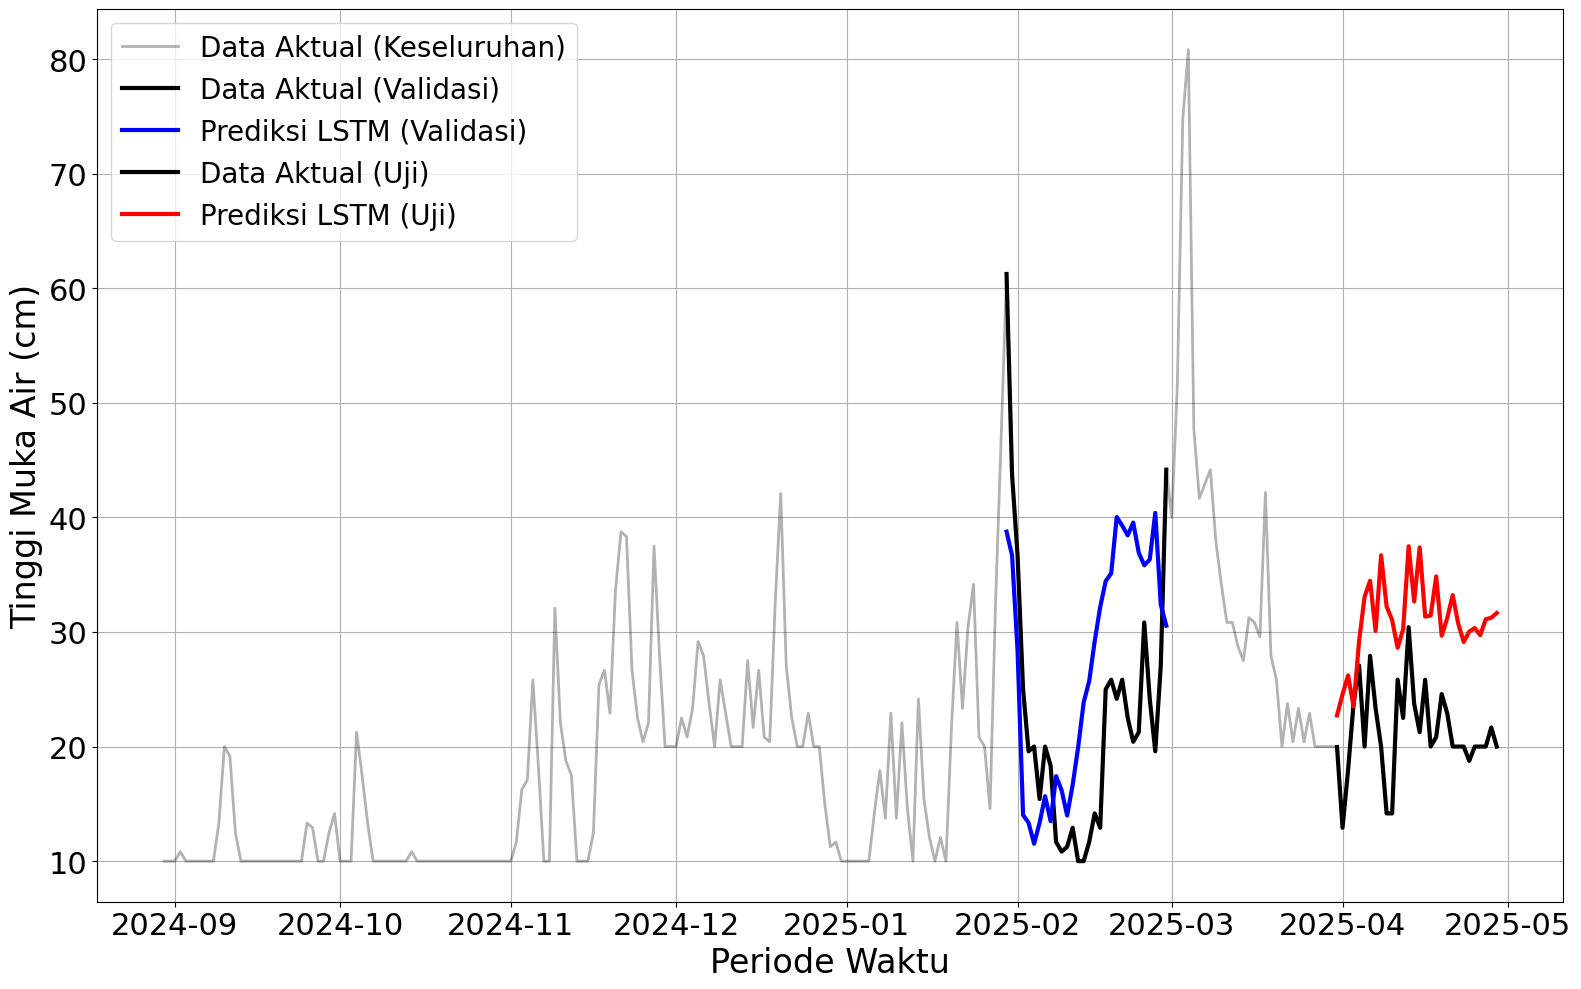

In [11]:
# Prediksi pada data validasi
pred_val = model.predict(X_val)
inv_val = scaler.inverse_transform(np.concatenate((X_val[:, -1], pred_val.reshape(-1, 1)), axis=1))[:, 1]

# Prediksi pada data uji
pred_test = model.predict(X_test)
inv_test = scaler.inverse_transform(np.concatenate((X_test[:, -1], pred_test.reshape(-1, 1)), axis=1))[:, 1]

# Menentukan index waktu yang sesuai
val_start_idx = train_size + seq_length
val_end_idx = val_start_idx + len(inv_val)

test_start_idx = train_size + val_size + seq_length
test_end_idx = test_start_idx + len(inv_test)

plt.figure(figsize=(16, 10))

# 1. Plot keseluruhan data aktual (train + val + test)
plt.plot(data['Daily_Period'], data['TMA_Daily'].values,
         lw=2, label='Data Aktual (Keseluruhan)', color='black', alpha=0.3)

# 2. Plot data aktual validasi
plt.plot(data['Daily_Period'][val_start_idx:val_end_idx],
         data['TMA_Daily'].values[val_start_idx:val_end_idx],
         lw=3, label='Data Aktual (Validasi)', color='black')

# 3. Plot prediksi validasi
plt.plot(data['Daily_Period'][val_start_idx:val_end_idx],
         inv_val, lw=3, label='Prediksi LSTM (Validasi)', color='blue')

# 4. Plot data aktual uji
plt.plot(data['Daily_Period'][test_start_idx:test_end_idx],
         data['TMA_Daily'].values[test_start_idx:test_end_idx],
         lw=3, label='Data Aktual (Uji)', color='black')

# 5. Plot prediksi uji
plt.plot(data['Daily_Period'][test_start_idx:test_end_idx],
         inv_test, lw=3, label='Prediksi LSTM (Uji)', color='red')

# Format
plt.xlabel('Periode Waktu', fontsize=24)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

# Nilai MAPE (Testing)

In [12]:
from sklearn.metrics import mean_absolute_percentage_error

# Indeks awal dan akhir validasi
val_start_idx = train_size + seq_length
val_end_idx = val_start_idx + len(inv_val)

# Indeks awal dan akhir uji
test_start_idx = train_size + val_size + seq_length
test_end_idx = test_start_idx + len(inv_test)

# MAPE Validasi (%)
mape_val = mean_absolute_percentage_error(
    data['TMA_Daily'].values[val_start_idx:val_end_idx],
    inv_val
) * 100

# MAPE Uji (%)
mape_test = mean_absolute_percentage_error(
    data['TMA_Daily'].values[test_start_idx:test_end_idx],
    inv_test
) * 100

# Tampilkan hasil dengan 2 desimal
print(f'MAPE Validasi: {mape_val:.2f}%')
print(f'MAPE Uji     : {mape_test:.2f}%')

MAPE Validasi: 55.77%
MAPE Uji     : 49.19%


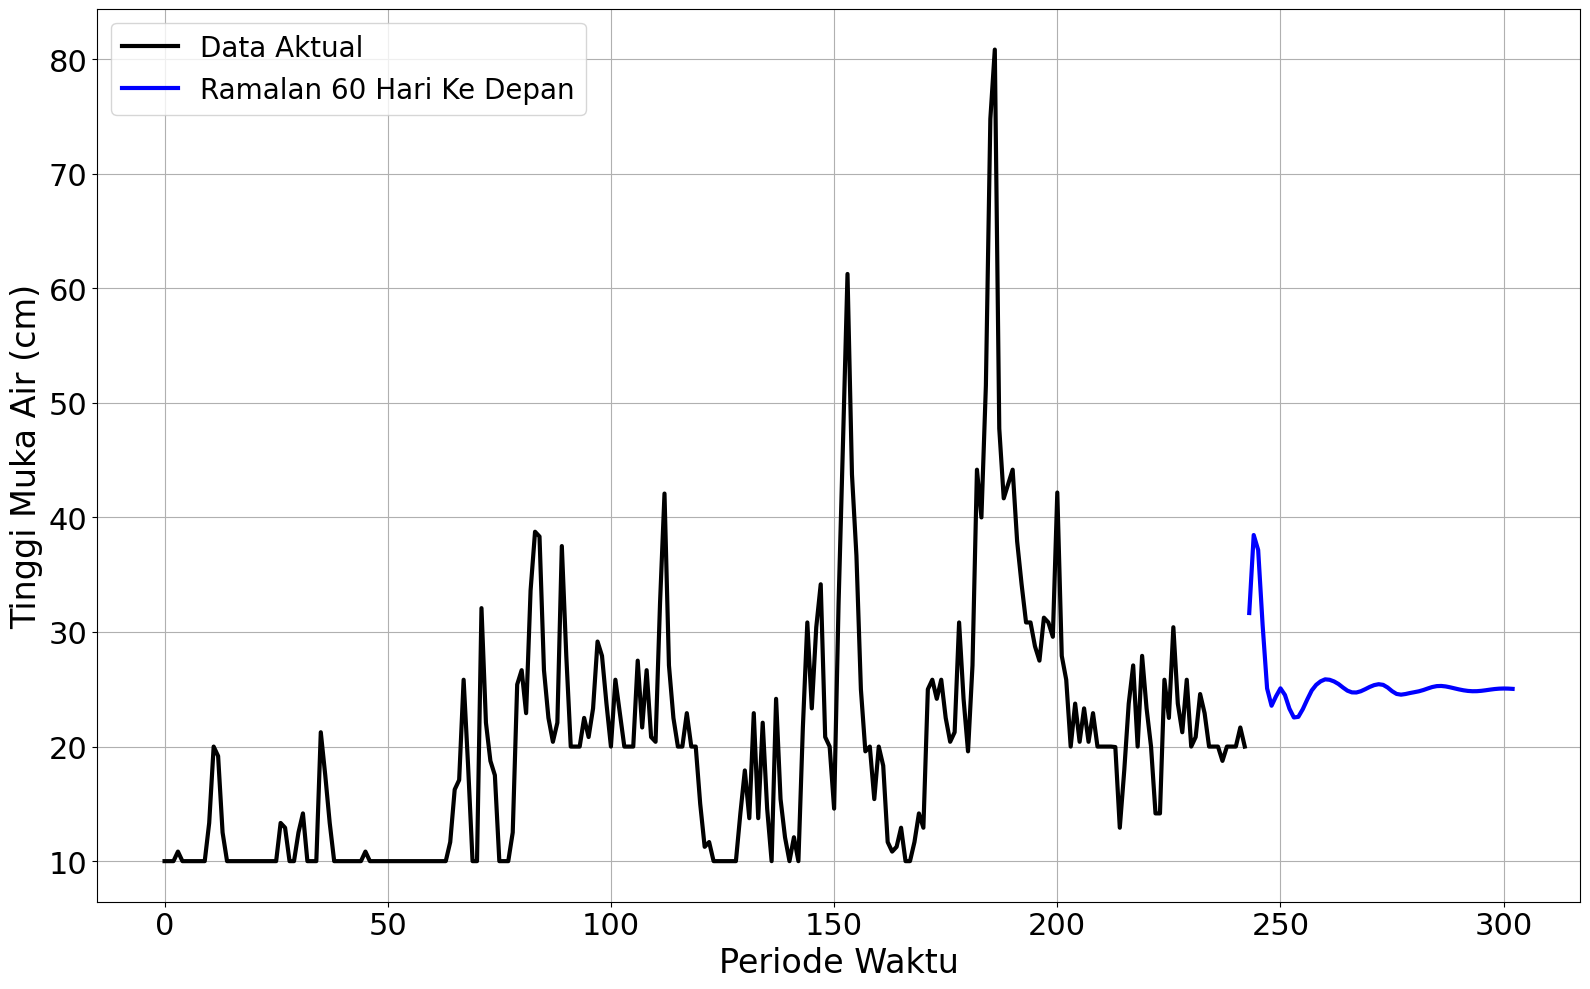

In [13]:
# Menentukan jumlah langkah ke depan yang ingin diramalkan
future_steps = 60

# Menggunakan data terakhir dari data uji sebagai input awal (tanpa target)
future_data = X_test[-1]  # Bentuk: (seq_length - 1, 1)

# Menyimpan hasil prediksi
future_predictions = []

for i in range(future_steps):
    # Prediksi 1 langkah ke depan
    prediction = model.predict(future_data.reshape(1, seq_length - 1, 1), verbose=0)
    future_predictions.append(prediction[0, 0])

    # Perbarui input untuk prediksi berikutnya
    future_data = np.append(future_data[1:], prediction[0])  # geser & tambahkan prediksi baru
    future_data = future_data.reshape(seq_length - 1, 1)

# Invers transform hasil prediksi ke skala asli (cm)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Visualisasi gabungan data aktual + hasil ramalan
plt.figure(figsize=(16, 10))

# 1. Data aktual (Train + Val + Test) dalam skala asli
plt.plot(np.arange(len(time_series_data)),
         scaler.inverse_transform(time_series_data),
         lw=3, label='Data Aktual', color='black')

# 2. Hasil prediksi ke depan (setelah akhir data uji)
plt.plot(np.arange(len(time_series_data), len(time_series_data) + future_steps),
         future_predictions, lw=3, label='Ramalan 60 Hari Ke Depan', color='blue')

# Label dan tampilan
plt.legend(loc = 'upper left', fontsize=20)
plt.xlabel('Periode Waktu', fontsize=24)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.title('Peramalan 60 Hari Ke Depan Menggunakan Model LSTM', fontsize=22)
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Mengubah hasil prediksi masa depan menjadi DataFrame
future_predictions = pd.DataFrame(future_predictions, columns=['Prediksi_TMA'])

# Tampilkan hasil prediksi ke depan
print(future_predictions)

# Simpan hasil prediksi ke file Excel
future_predictions.to_excel("lstm_forecast_futurepred_3way_split.xlsx", index=False)

    Prediksi_TMA
0      31.655857
1      38.463104
2      37.161751
3      30.592045
4      25.076071
5      23.564396
6      24.386694
7      25.081734
8      24.502924
9      23.310913
10     22.541059
11     22.593410
12     23.266253
13     24.110720
14     24.897768
15     25.390209
16     25.694786
17     25.868296
18     25.829735
19     25.684452
20     25.458715
21     25.153082
22     24.878445
23     24.730257
24     24.720383
25     24.829681
26     25.009590
27     25.207331
28     25.364601
29     25.443411
30     25.386141
31     25.155870
32     24.834641
33     24.595728
34     24.529781
35     24.586391
36     24.673393
37     24.746685
38     24.824108
39     24.933903
40     25.070215
41     25.196741
42     25.275843
43     25.290956
44     25.249121
45     25.171274
46     25.079060
47     24.988607
48     24.911724
49     24.857044
50     24.830534
51     24.834648
52     24.866249
53     24.916279
54     24.972246
55     25.021631
56     25.054899
57     25.0672

# Plot Forecasting

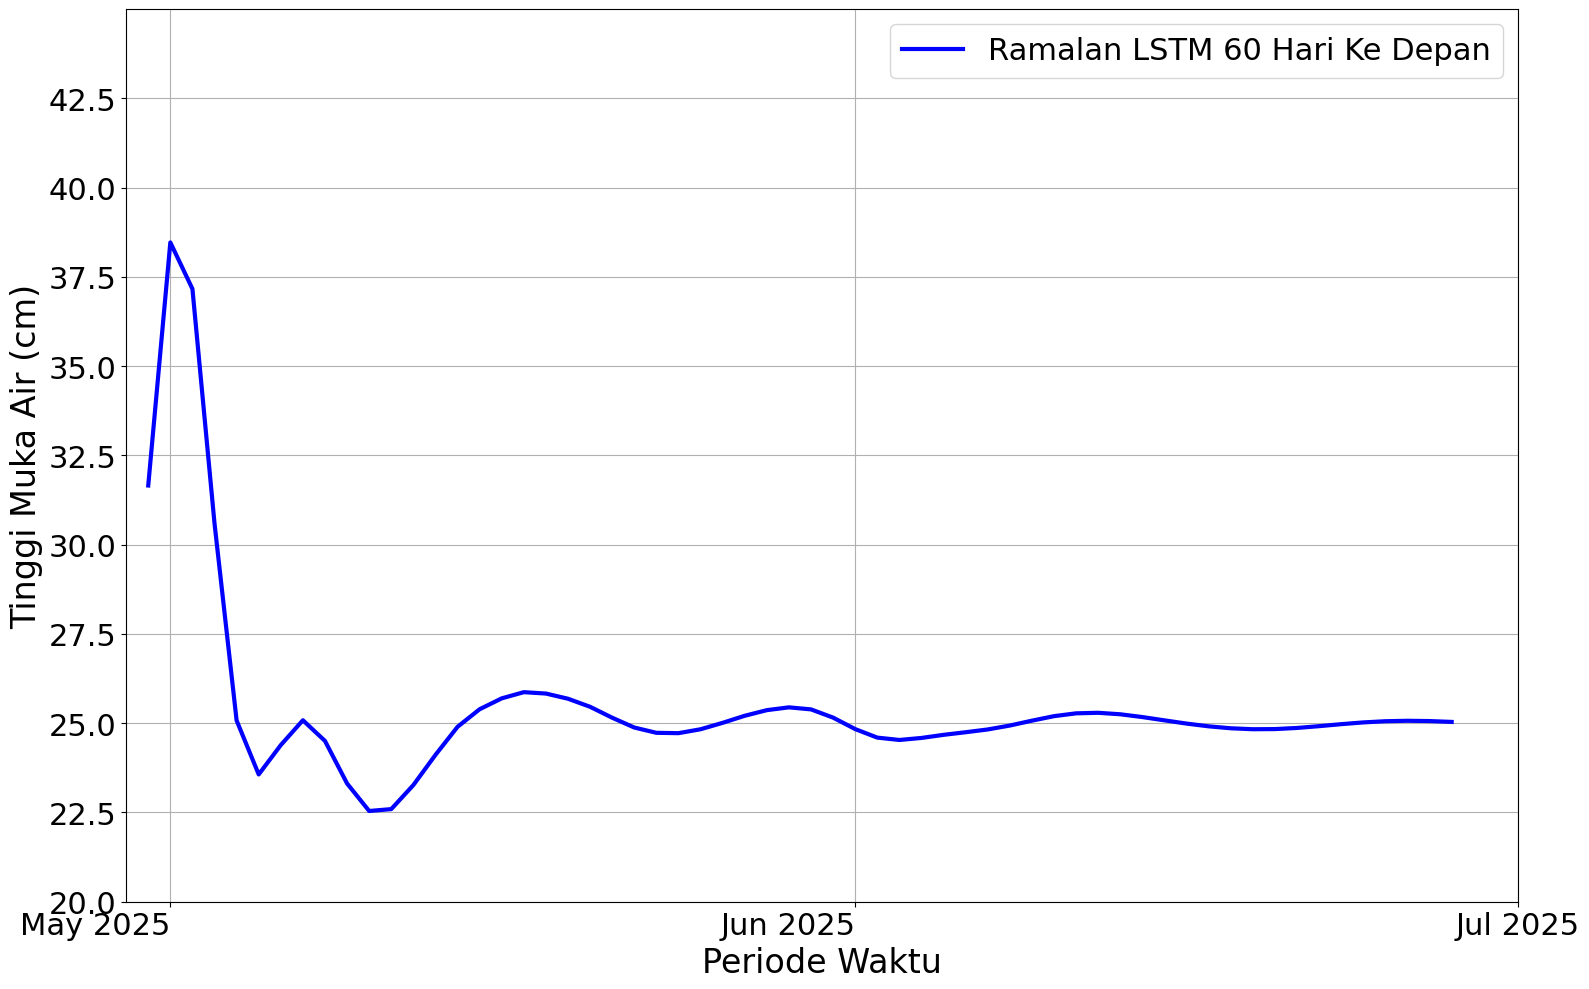

In [15]:
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

# Generate future dates starting from the day after the last date in the original data
last_date = data['Daily_Period'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Visualisasi hasil prediksi ke depan (tanpa data aktual)
plt.figure(figsize=(16, 10))
plt.plot(future_dates, future_predictions, lw=3, label='Ramalan LSTM 60 Hari Ke Depan', color='blue')

# Label sumbu dan ukuran font
plt.xlabel('Periode Waktu', fontsize=24)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(np.arange(20, 45, 2.5), fontsize=22)
plt.ylim(top=45)

# Format label tanggal pada sumbu X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate(rotation=0)

# Atur batas akhir tampilan waktu prediksi
end_date = pd.to_datetime('2025-07-01')
plt.xlim(last_date, end_date)

# Tambahkan grid dan legend
plt.grid(True)
plt.legend(fontsize=22)
plt.tight_layout()
plt.show()

# Plot Test vs Aktual vs Forecast

In [16]:
data = pd.read_csv('https://raw.githubusercontent.com/Mluthfialgifari/Tugas-Akhir-Skripsi/refs/heads/main/Revisi%20Analisis/Data%20TMA%20(Jan%202022%20-%20Juni%202025).csv')
data = data.loc[:, ['Daily_Period', 'TMA_Daily']]

data = data.iloc[:1275].reset_index(drop=True)

print(data.head())
print(data.tail())

  Daily_Period  TMA_Daily
0   01/01/2022       10.0
1   02/01/2022       10.0
2   03/01/2022       10.0
3   04/01/2022       10.0
4   05/01/2022       12.5
     Daily_Period  TMA_Daily
1270   24/06/2025  15.000000
1271   25/06/2025  15.416667
1272   26/06/2025  10.000000
1273   27/06/2025  10.000000
1274   28/06/2025  15.833333


Jumlah data uji: 60
Jumlah data aktual forecast: 60
Tanggal awal prediksi: 2025-04-30 00:00:00
Tanggal akhir prediksi: 2025-06-28 00:00:00


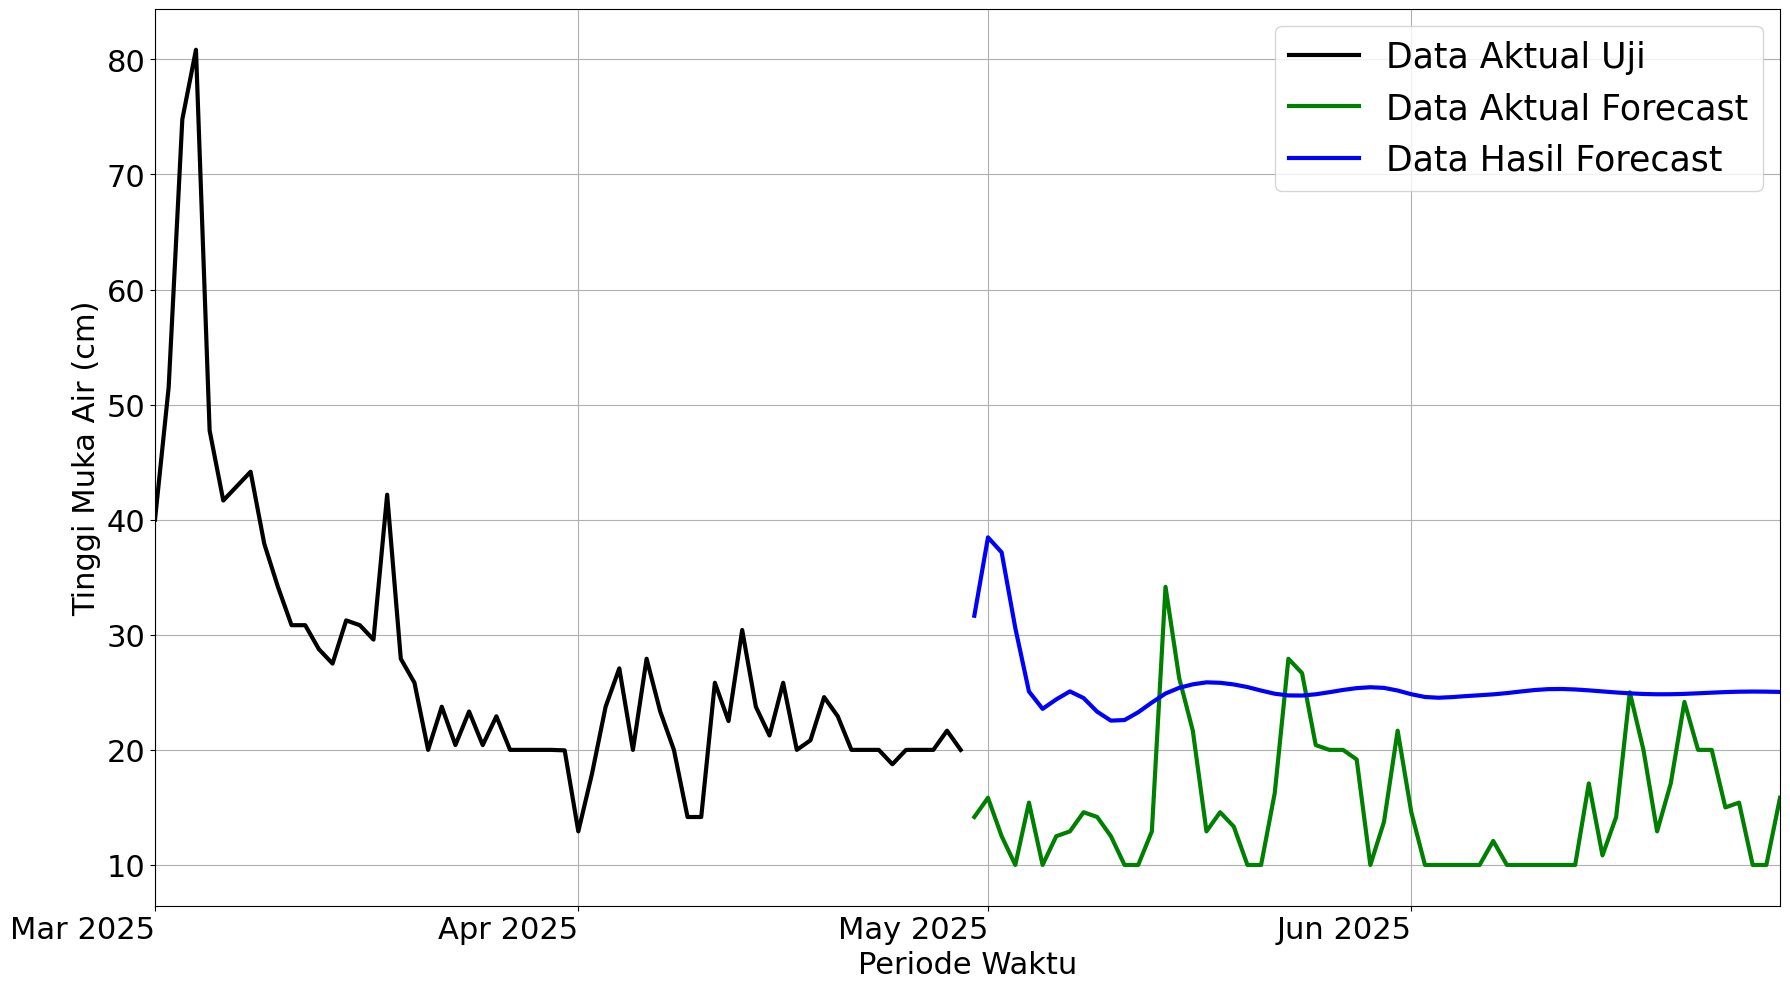

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data_full = data.iloc[:1275].reset_index(drop=True)
# Ubah kolom tanggal ke format datetime
data_full['Daily_Period'] = pd.to_datetime(data_full['Daily_Period'], dayfirst=True)

# --- DEFINISI PERIODE ---
test_start = pd.to_datetime('01/03/2025', dayfirst=True)
test_end = pd.to_datetime('29/04/2025', dayfirst=True)

forecast_actual_start = pd.to_datetime('30/04/2025', dayfirst=True)
forecast_actual_end = pd.to_datetime('28/06/2025', dayfirst=True)

# --- FILTER DATA ---
test_data = data_full[(data_full['Daily_Period'] >= test_start) & (data_full['Daily_Period'] <= test_end)]
actual_forecast_data = data_full[(data_full['Daily_Period'] >= forecast_actual_start) & (data_full['Daily_Period'] <= forecast_actual_end)]

# --- CEK DATA ---
print("Jumlah data uji:", len(test_data))
print("Jumlah data aktual forecast:", len(actual_forecast_data))
print("Tanggal awal prediksi:", future_dates[0])
print("Tanggal akhir prediksi:", future_dates[-1])

# --- (Opsional) Inverse transform jika belum ---
try:
    future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1)).flatten()
except:
    pass

# --- PLOT ---
plt.figure(figsize=(18, 10))

# 1. Plot Data Test
plt.plot(test_data['Daily_Period'], test_data['TMA_Daily'],
         color='black', linewidth=3, label='Data Aktual Uji')

# 2. Plot Data Aktual Forecast
plt.plot(actual_forecast_data['Daily_Period'], actual_forecast_data['TMA_Daily'],
         color='green', linewidth=3, label='Data Aktual Forecast')

# 3. Plot Forecasting
plt.plot(future_dates, future_predictions,
         color='blue', linewidth=3, label='Data Hasil Forecast')

# --- FORMAT PLOT ---
plt.xlabel('Periode Waktu', fontsize=22)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=22)
# plt.title('Perbandingan Data Uji, Aktual Forecast, dan Hasil Forecasting', fontsize=24)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=25)
plt.grid(True)

# Atur format tanggal: tampilkan bulan dan tahun (misal: Mar 2025)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Tampilkan label setiap awal bulan
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Putar label tanggal agar tidak saling tumpang tindih
plt.gcf().autofmt_xdate(rotation=0)

# Atur batas waktu agar sumbu X mencakup Maret–Juli 2025
plt.xlim(test_start, future_dates[-1])
plt.tight_layout()
plt.show()